In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import vice
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z, AGB_MODELS
from yields import y_c_agb, y_c_agb2
import yields
import scipy
from plotting import fig_saver
import pandas as pd
import apogee_analysis as aah
import matplotlib as mpl
from cycler import cycler

In [5]:
sf = fig_saver("figures/")
# plt.style.use('dark_background')

In [53]:
plt.rcParams["text.color"] = "black"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["font.size"] = 20

Text(0.5, 1.0, 'Fractional contribution to metallicity')

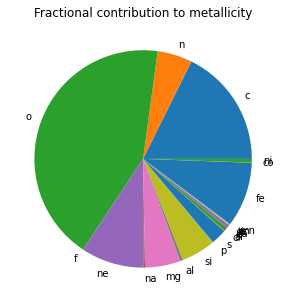

In [6]:
plt.figure(figsize=(10,5))
names = vice.solar_z.keys()[1:24]
values = [vice.solar_z(name)/0.01335 for name in names]
plt.pie(values, labels=names);
plt.title("Fractional contribution to metallicity")

# AGB Modle Parameters Comparison

# AGB Carbon Yields

In [7]:
cmap = mpl.cm.plasma

In [8]:
def plot_c_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    Z_max = 0.02
    Z_min = 0.0001
    
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        c = (np.log(z) - np.log(Z_min))/np.log(Z_max/Z_min)
        f = ax.plot(m1, y, label=f"Z = {z}", c=cmap(c), **kwargs)

    #ax.set_xlabel("stellar mass")
    #ax.set_ylabel("$y_C^{agb}$")
    ax.set_title(study)
    # fig.legend()
    return f

In [9]:
def plot_weighted_c_yields(study = "cristallo11", Z = 0.014):
    interpolator = vice.yields.agb.interpolator("c", study=study)
    
    masses = interpolator.masses
    y = [interpolator(m, Z) for m in masses]
    
    plt.plot(masses, np.array(y)*np.array(masses)**-1.3, label=study)

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    plt.legend()

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

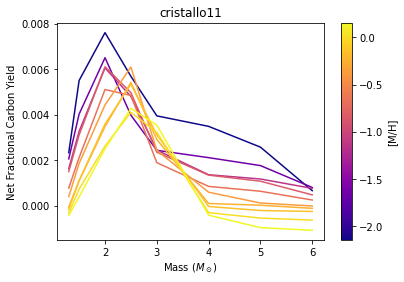

In [11]:
plot_c_table()
norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(mappable, label="[M/H]")
plt.xlabel("Mass ($M_\odot$)")
plt.ylabel("Net Fractional Carbon Yield")
sf("c11_agb_m_z")

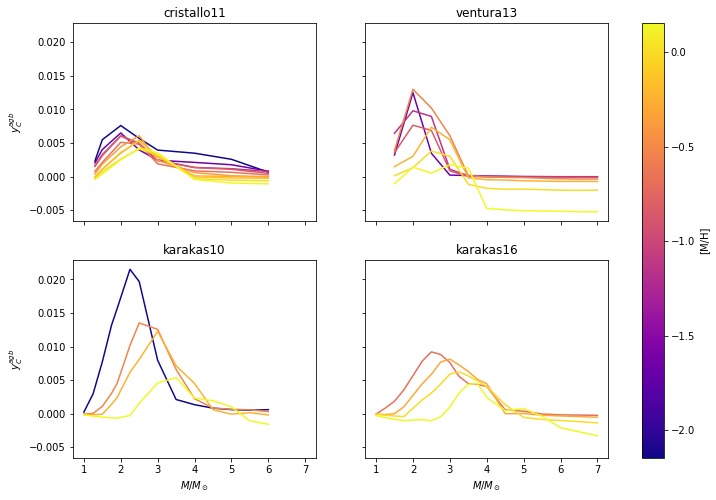

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for i in range(4):
    study = AGB_MODELS[i]
    ax = axs[i%2][i//2]
    f = plot_c_table(study, ax=ax, fig=fig)
    ax.axhline(0, c="white", ls="--", zorder=-1)
    #plt.legend()



norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(mappable, ax=axs.ravel().tolist(), label="[M/H]")

plt.setp(axs[-1, :], xlabel='$M/M_\odot$')
plt.setp(axs[:, 0], ylabel='$y_C^{agb}$')

sf("yields_C_stellar_models")   

In [13]:
def plot_cpn_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    Z_max = 0.02
    Z_min = 0.0001
    
    yc, m1, z1 = vice.yields.agb.grid('c', study=study)
    yn, _, _ = vice.yields.agb.grid("n", study=study)
    y1 = np.array(yc) + np.array(yn)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        c = (np.log(z) - np.log(Z_min))/np.log(Z_max/Z_min)
        ax.plot(m1, y, label=f"Z = {z}", c=cmap(c), **kwargs)

    ax.set_xlabel("stellar mass")
    ax.set_ylabel("$y_{C+N}^{agb}$")
    # plt.legend()
    ax.set_title(study)

In [14]:
def plot_cno_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    Z_max = 0.02
    Z_min = 0.0001
    
    yc, m1, z1 = vice.yields.agb.grid('c', study=study)
    yn, _, _ = vice.yields.agb.grid("n", study=study)
    yo, _, _ = vice.yields.agb.grid("o", study=study)
    y1 = np.array(yc)/12 + np.array(yn)/14 + np.array(yo)/16
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        c = (np.log(z) - np.log(Z_min))/np.log(Z_max/Z_min)
        ax.plot(m1, y, label=f"Z = {z}", c=cmap(c), **kwargs)

    ax.set_xlabel("stellar mass")
    ax.set_ylabel("$y_{CNO}^{agb}$")
    # plt.legend()
    ax.set_title(study)

In [15]:
def plot_n_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    Z_max = 0.02
    Z_min = 0.0001
    
    yc, m1, z1 = vice.yields.agb.grid('c', study=study)
    yn, _, _ = vice.yields.agb.grid("n", study=study)
    yo, _, _ = vice.yields.agb.grid("o", study=study)
    y1 = np.array(yn)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]
        c = (np.log(z) - np.log(Z_min))/np.log(Z_max/Z_min)
        ax.plot(m1, y, label=f"Z = {z}", c=cmap(c), **kwargs)

    ax.set_xlabel("stellar mass")
    ax.set_ylabel("$y_{N}^{agb}$")
    # plt.legend()
    ax.set_title(study)

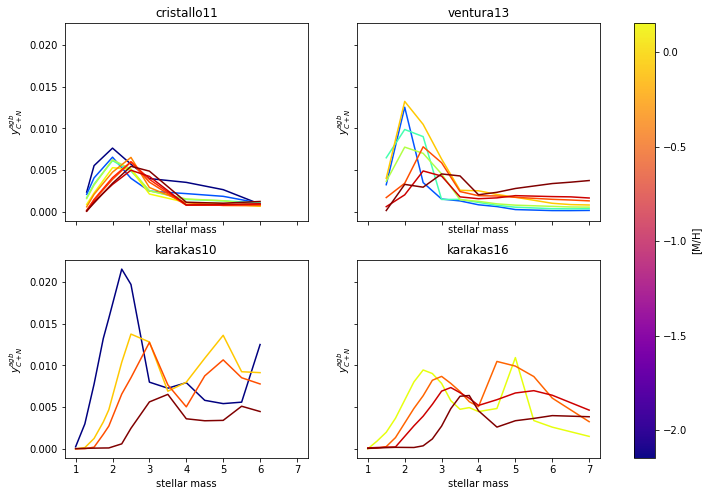

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for i in range(4):
    study = AGB_MODELS[i]
    ax = axs[i%2][i//2]
    f = plot_cpn_table(study, ax=ax, fig=fig)



norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(mappable, ax=axs.ravel().tolist(), label="[M/H]")

sf("yields_CPN_stellar_models")  

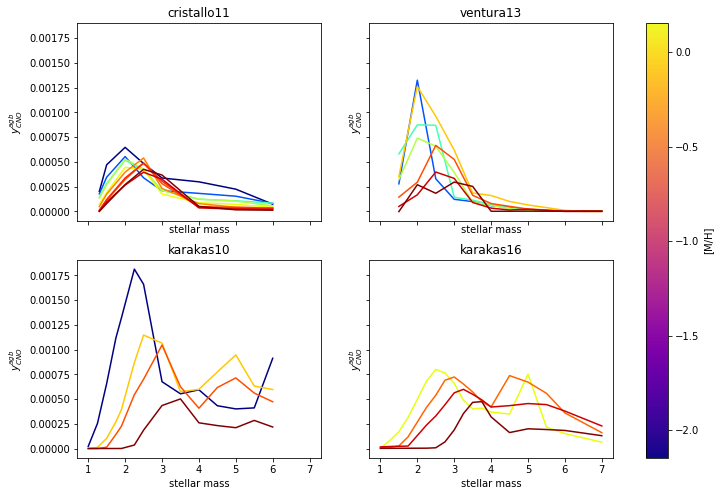

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for i in range(4):
    study = AGB_MODELS[i]
    ax = axs[i%2][i//2]
    f = plot_cno_table(study, ax=ax, fig=fig)




norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(mappable, ax=axs.ravel().tolist(), label="[M/H]")
    
sf("yields_CNO_stellar_models") 


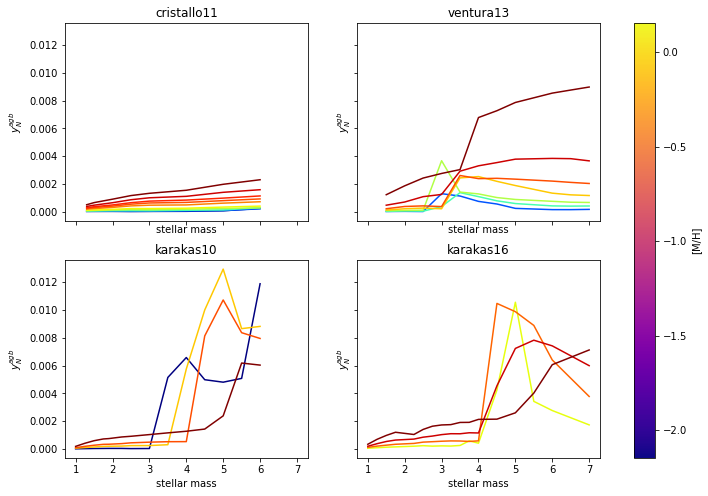

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for i in range(4):
    study = AGB_MODELS[i]
    ax = axs[i%2][i//2]
    f = plot_n_table(study, ax=ax, fig=fig)

norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(mappable, ax=axs.ravel().tolist(), label="[M/H]")

sf("yields_N_stellar_models")  

0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882
0.16345058391526882


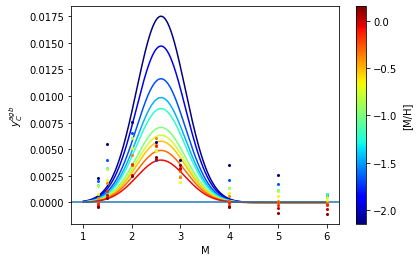

In [19]:
Z_vals = [0.0001,0.0003,0.001,0.002,0.003,0.006, 0.008, 0.01, 0.014, 0.02]
cmap = plt.get_cmap("jet")
fig, ax = plt.subplots()
for i in range(len(Z_vals)):
    Z = Z_vals[i]
    x = np.linspace(1, 6, 1000)
    y = yields.y_c_gauss()(x, Z)
    plt.plot(x, y, label=Z, c=cmap(i/len(Z_vals)))
plt.axhline(0)
plot_c_table("cristallo11", marker="o", ms=2, lw=0, ax=ax, fig=fig)
#plot_c_table("ventura13", marker="^", ms=2, lw=0, ax=ax, fig=fig,)
#plot_c_table("karakas10", marker="*", ms=2, lw=0, ax=ax, fig=fig, )
#plot_c_table("karakas16", marker="+", ms=2, lw=0, ax=ax, fig=fig)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(mappable,label="[M/H]")

plt.xlabel("M")
plt.ylabel("$y_C^{agb}$")
plt.title("")
sf("y_c_agb_analytic")

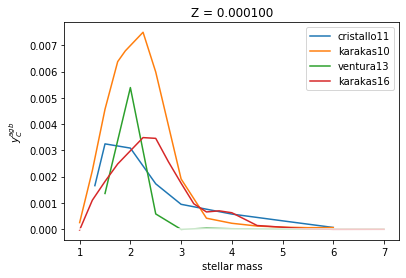

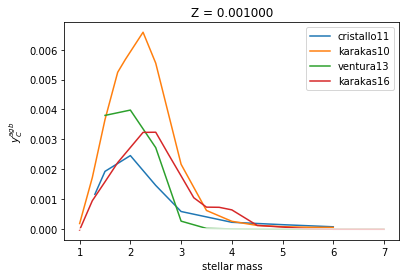

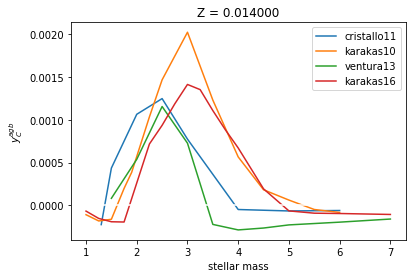

In [20]:
for Z in [0.0001, 0.001, 0.014]:
    for study in AGB_MODELS:
        plot_weighted_c_yields(study, Z=Z)

    plt.axhline(0, c="white")
    plt.title("Z = %f" % Z)

    sf("weighted_yields_C_agb_to_mass_logZ%i" % (np.log10(Z)))
    #x = np.linspace(1, 6)
    #y = y_c_agb(m0=2.6)(x, Z)*x**-1.3
    #plt.plot(x, y, c="black")
    #plt.ylim(-0.002, 0.008)
    #plt.show()
    


# CCSNE Carbon Yields

In [21]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }
allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

ccsne_studies = ["LC18", "S16/N20", "WW95","NKT13"]
cmap = plt.get_cmap("jet")
N = len(ccsne_studies)

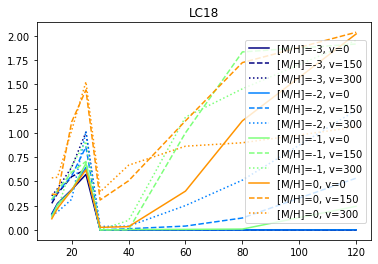

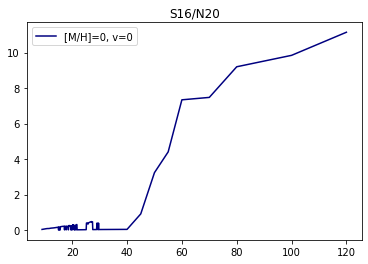

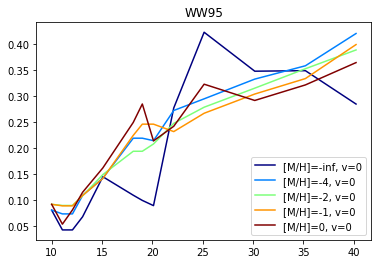

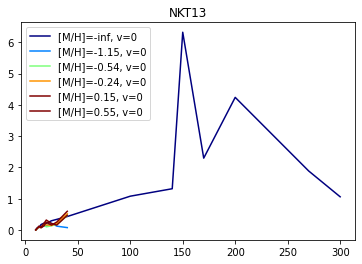

In [22]:
for study in ccsne_studies:
    metalicities = allowed_MoverH[study]
    
    n = len(metalicities)
    rotations = allowed_rotations[study]
    for i in range(n):
        for j in range(len(rotations)):
            rotation = rotations[j]
            MoverH = metalicities[i]
            table = vice.yields.ccsne.table("c", study=study, MoverH=MoverH, rotation=rotation)
            masses = table.masses
            m_yields = [table[mass] for mass in masses]

            plt.plot(masses, m_yields, label=f"[M/H]={MoverH}, v={rotation}", color=cmap(i/N), linestyle=["-", "--", ":"][j])
        
    plt.title(study)
    plt.legend()
    
    # sf("yields_C_ccsne_to_mass_" + study.replace("/", ""))
    plt.show()

In [23]:
def y_o(z):
    return 0.015

def y_cc(z):
    return y_o(z) * 0.5* (z/0.014)**0.2

<ipython-input-24-1cc669505865>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-24-1cc669505865>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-24-1cc669505865>:18: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(Z), y, color=["b", "orange", "g", "r"][i], label=f"{study}, v={rotation}", marker=marker)
<ipython-input-24-1cc669505865>:8: ScienceWarning: Supernovae yields from the Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 

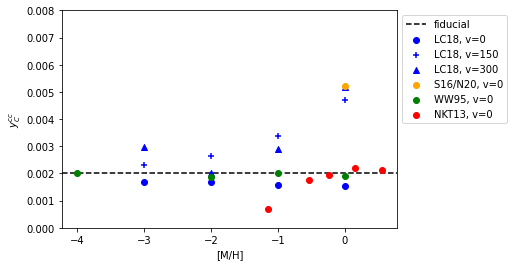

In [24]:

for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=["b", "orange", "g", "r"][i], label=f"{study}, v={rotation}", marker=marker)

#plt.axhline(0.002, ls="--", color="k", zorder=-1, label="fiducial")
#plt.xscale("log")
plt.ylim([0, 0.008])
plt.legend(bbox_to_anchor=(1,1), loc="upper left")


#x = np.linspace(-4, 1)
#y = y_cc(0.014*10**x)
#plt.plot(x, y)
plt.xlabel("[M/H]")
plt.ylabel(r"$y_C^{cc}$")
sf("CCSN_C_yields_to_Z")


<ipython-input-25-db262816768f>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-25-db262816768f>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-25-db262816768f>:18: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)
<ipython-input-25-db262816768f>:8: ScienceWarning: Supernovae yields from the Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 457 study are sampl

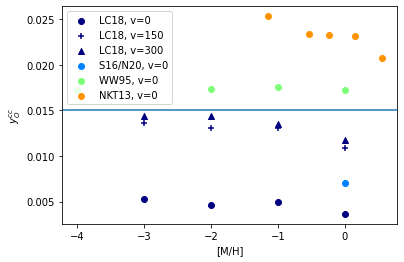

In [25]:
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)

plt.legend()
plt.axhline(0.015)


plt.xlabel("[M/H]")
plt.ylabel(r"$y_O^{cc}$")

#plt.yscale("log")
sf("CCSN_O_yields_to_Z")

<ipython-input-26-846babaf2feb>:9: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('n', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-26-846babaf2feb>:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('n', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-26-846babaf2feb>:19: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)
<ipython-input-26-846babaf2feb>:9: ScienceWarning: Supernovae yields from the Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 457 study are sampl

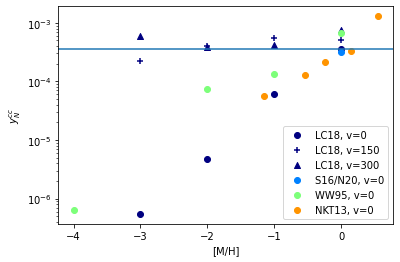

In [26]:
cmap = mpl.cm.jet
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('n', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)

plt.legend()
plt.axhline(3.6e-4)

#plt.ylim([0, 0.008])
plt.xlabel("[M/H]")
plt.ylabel(r"$y_N^{cc}$")

plt.yscale("log")
sf("CCSN_N_yields_to_Z")

In [27]:
y_o(0)

0.015

In [28]:
y_cc(0.014)

0.0075

<ipython-input-29-ccabb4f40341>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-29-ccabb4f40341>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-29-ccabb4f40341>:10: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  yo = [vice.yields.ccsne.fract

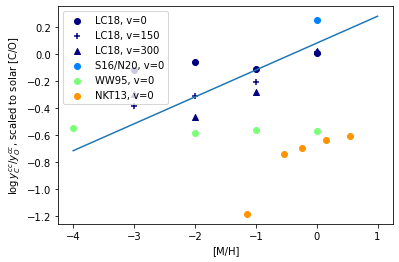

In [29]:
for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
              for metalicity in metalicities]
        y = np.log10(np.array(yc)/yo) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)

plt.legend()
#plt.legend(loc="lower left")
#plt.axhline(0)
#plt.axhline(-0.49, ls="--")

x = np.linspace(-4, 1)

m_h = np.linspace(-4, 1, 100)
z = 0.014*10**m_h
y = np.log10(y_cc(z)/y_o(z)) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y)


#plt.ylim([0, 0.008])
plt.xlabel("[M/H]")
plt.ylabel(r"$\log y_C^{cc}/y_O^{cc}$, scaled to solar [C/O]")

sf("CCSN_CO_yields_to_Z")

<ipython-input-30-f340004df2f1>:8: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-30-f340004df2f1>:8: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-30-f340004df2f1>:10: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  yo = [vice.yields.ccsne.fract

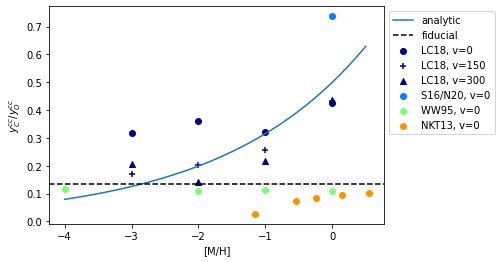

In [30]:
for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('o', study=study, MoverH=metalicity, rotation=rotation)[0]
              for metalicity in metalicities]
        y = np.array(yc)/yo
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)

#plt.legend(loc="lower left")
#plt.axhline(0)
#plt.axhline(-0.49, ls="--")

x = np.linspace(-4, 1)

m_h = np.linspace(-4, 0.5, 100)
z = 0.014*10**m_h
y = y_cc(z)/0.015# - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, label="analytic")

plt.axhline(0.002/0.015, color="k", ls="--", label="fiducial")

#plt.ylim([0, 0.008])
plt.xlabel("[M/H]")
plt.ylabel(r"$y_C^{cc}/y_O^{cc}$")

#plt.yscale("log")

#plt.scatter(0, vice.solar_z("c")/vice.solar_z("o"), marker="*", s=200, c="yellow", zorder=-1, label="sun")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")


sf("CCSN_CO_yields_to_Z")

In [31]:
plt.legend?

In [32]:
fraction = 0.2
M_Hs = [-3, -2, -1, 0]

y_n = [(1-fraction) * 3.6e-4 + fraction*vice.yields.ccsne.fractional("n", MoverH=M_H, rotation=300, study="LC18")[0] for M_H in M_Hs]
Z = [0.014*10**M_H for M_H in M_Hs]
# f = vice.toolkit.interpolation.interp_scheme_1d(Z, y_c)
f_n = vice.toolkit.interpolation.interp_scheme_1d(Z, y_n)

In [33]:
f_n(0.014/10)

0.00037330283460871

# AGB Single Stellar Population Yields

In [34]:
vice.single_stellar_population?

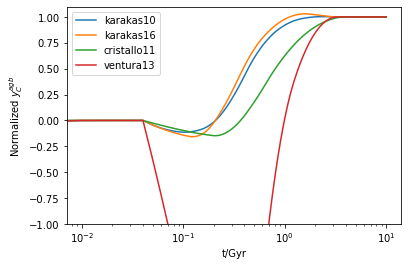

In [35]:
for model in ["karakas10", "karakas16", "cristallo11", "ventura13"]:
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014)
    m_c = [c - 0.002*1e6 for c in m_c]
    plt.plot(times, np.array(m_c)/m_c[-1], label=model)
    
    
#vice.yields.agb.settings["c"] = yields.y_c_gauss()
#m_c, times = vice.single_stellar_population("c", Z=0.014)
#m_c = [c - 0.002*1e6 for c in m_c]
#plt.plot(times, np.array(m_c)/m_c[-1], label="analytic")

plt.xlabel("t/Gyr")
plt.ylabel("Normalized $y_C^{agb}$")
plt.xscale("log")
plt.legend()
plt.ylim(-1, 1.1)
sf("y_C_agb_to_t")


0.16345058391526882


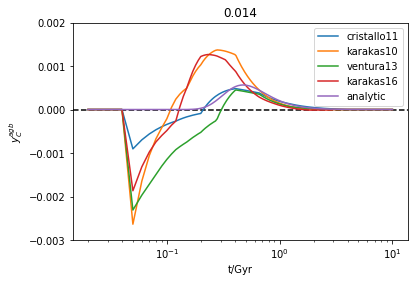

0.16345058391526882


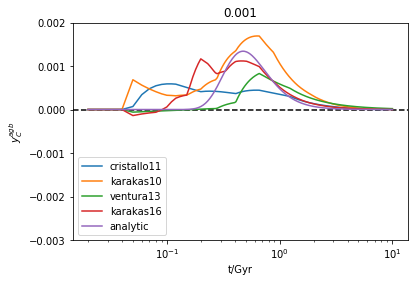

0.16345058391526882


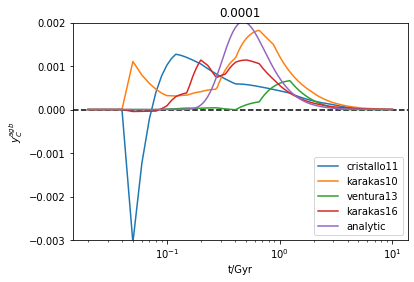

In [36]:
def plot_dtd(Z=0.014, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z)
    y_c_cc = 0.002
    m_c = np.array([c/1e6 - y_c_cc for c in m_c])
    dt = times[1] - times[0]
    y = (m_c[1:] - m_c[:-1])/dt
    plt.plot(times[2:], y[1:], **kwargs)

for Z in [0.014, 0.001, 0.0001]:
    for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
        vice.yields.agb.settings["c"] = model
        plot_dtd(label=model, Z=Z)
    vice.yields.agb.settings["c"] = yields.y_c_gauss()
    plot_dtd(label="analytic", Z=Z)


    #vice.yields.agb.settings["c"] = yields.y_c_agb()
    #plot_dtd(label="analytic", Z=Z)


    plt.xlabel("t/Gyr")
    plt.ylabel("$y_C^{agb}$")
    plt.xscale("log")
    #plt.xlim(0, 2)
    plt.axhline(0, color="k", ls="--", zorder=0)
    plt.legend()
    plt.ylim(-0.003, 0.002)
    plt.title(Z)
    sf("agb_dtd_%s" % Z)


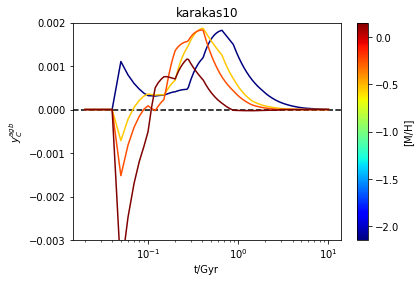

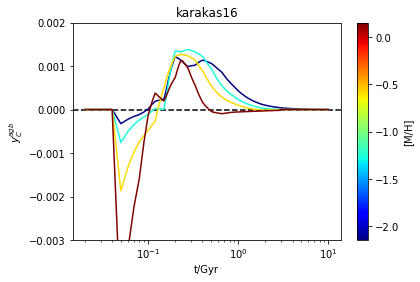

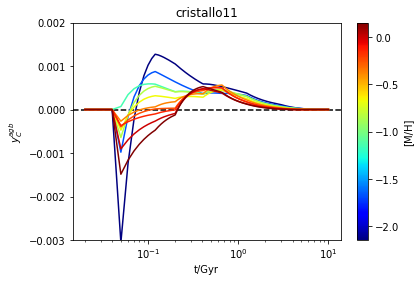

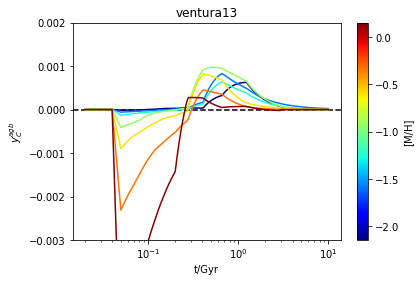

In [37]:
def plot_dtd(Z=0.014, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z)
    y_c_cc = 0.002
    m_c = np.array([c/1e6 - y_c_cc for c in m_c])
    dt = times[1] - times[0]
    y = (m_c[1:] - m_c[:-1])/dt
    plt.plot(times[2:], y[1:], **kwargs)


for model in ["karakas10", "karakas16", "cristallo11", "ventura13"]:
    y1, m1, z1 = vice.yields.agb.grid('c', study=model)
    N = len(z1)
    cmap = plt.get_cmap('jet')
    Z_max = max(z1)
    Z_min=min(z1)
    for Z in z1:
        vice.yields.agb.settings["c"] = model
        c = (np.log(Z) - np.log(Z_min))/np.log(Z_max/Z_min)
        plot_dtd(label=Z, Z=Z, c=cmap(c))


    plt.xlabel("t/Gyr")
    plt.ylabel("$y_C^{agb}$")
    plt.xscale("log")
    #plt.xlim(0, 2)
    plt.axhline(0, color="k", ls="--", zorder=0)
    # plt.legend()
    plt.ylim(-0.003, 0.002)
    plt.title(model)
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(mappable, label="[M/H]")
    plt.show()
    #sf("agb_dtd")


In [38]:
yc, m1, z1 = vice.yields.agb.grid('c', study="cristallo11")


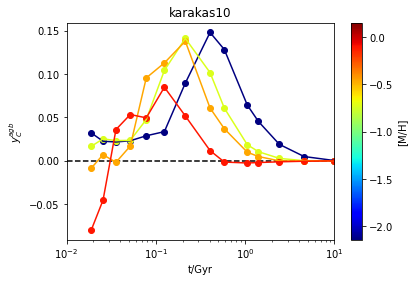

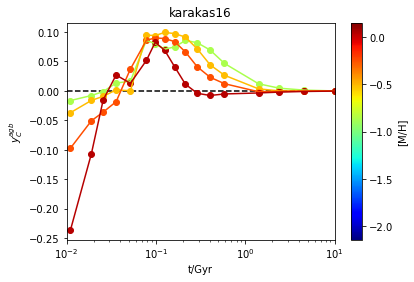

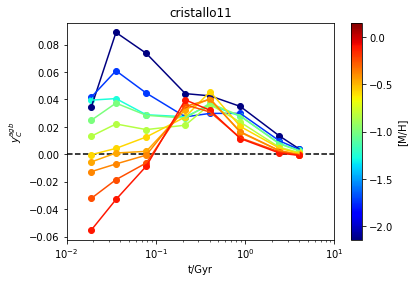

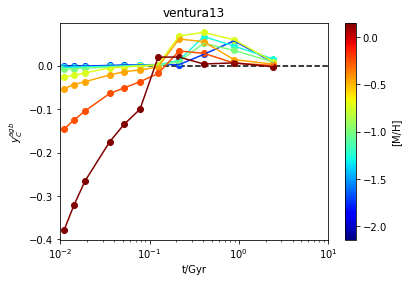

In [39]:
Z_min = 0.0001
Z_max = 0.04
def plot_dtd(Z = Z, study="cristallo11", **kwargs):
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    t1 = 10*np.array(m1)**-3.5
    N = len(z1)
    cmap = plt.get_cmap('jet')

    for i in range(N):
        y = np.array(y1)[:,i] * np.array(m1)**2.2
        z = z1[i]
        c = (np.log(z) - np.log(Z_min))/np.log(Z_max/Z_min)
        plt.plot(t1, y, label=f"Z = {z}", c=cmap(c), **kwargs)
        plt.scatter(t1, y, color=cmap(c), marker="o", **kwargs)



for model in ["karakas10", "karakas16", "cristallo11", "ventura13"]:
    plot_dtd(study=model)

    plt.xlabel("t/Gyr")
    plt.ylabel("$y_C^{agb}$")
    plt.xscale("log")
    #plt.xlim(0, 2)
    plt.axhline(0, color="k", ls="--", zorder=0)
    
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=np.log10(0.0001/0.014), vmax=np.log10(0.02/0.014))
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(mappable, label="[M/H]")
    #plt.ylim(-0.003, 0.002)
    plt.title(model)
    plt.xlim(1e-2, 1e1)
    plt.show()
#sf("agb_dtd")


In [40]:
import scipy

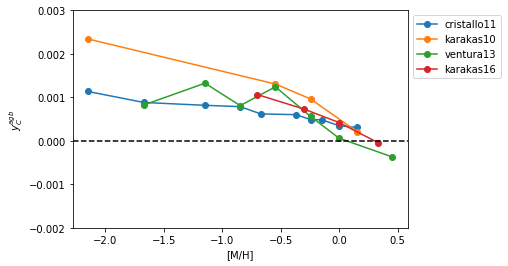

In [41]:
# for model in ["cristallo11", "karakas10","ventura13", "karakas16", y_c_agb(alpha=20), yields.amplified_yields("c", prefactor=10)]:
for model in ["cristallo11", "karakas10","ventura13", "karakas16"]:
    vice.yields.agb.settings["c"] = model
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    
    plt.plot(np.log10(Zs/0.014), np.array(mass_yields)/1e6 - 0.002, label=model, marker="o")

MoverH = np.linspace(-2, 1, 1000)
alpha = 0.001
beta = -20
b = 0.0004
a = -0.0003
#plt.plot(MoverH, b + a*MoverH, label="analytic")
plt.xlabel(r"[M/H]")
plt.ylabel("$y_C^{agb}$")
plt.ylim(-2e-3, 3e-3)
plt.axhline(0, c="black", linestyle="--")
#plt.scatter(0, vice.solar_z("c"), marker="*", color="green", label="sun")

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
sf("y_C_AGB_to_Z")




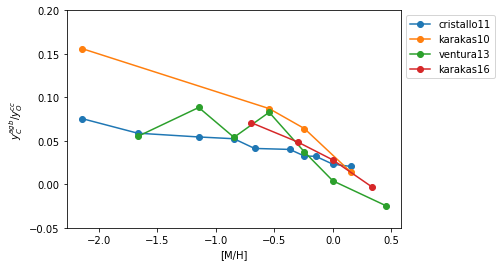

In [42]:
# for model in ["cristallo11", "karakas10","ventura13", "karakas16", y_c_agb(alpha=20), yields.amplified_yields("c", prefactor=10)]:
for model in ["cristallo11", "karakas10","ventura13", "karakas16"]:
    vice.yields.agb.settings["c"] = model
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 - 0.002
    y_o_cc = 0.015
    plt.plot(np.log10(Zs/0.014), y_c_agb/y_o_cc, label=model, marker="o")



plt.xlabel(r"[M/H]")
plt.ylabel("$y_C^{agb}/y_O^{cc}$")
plt.ylim(-5e-2, 2e-1)
#plt.axhline(0, c="black", ls=":")
#plt.scatter(0, vice.solar_z("c"), marker="*", color="green", label="sun")

plt.legend(bbox_to_anchor=(1,1), loc="upper left")


In [43]:
plt.legend?

In [44]:
allowed_MoverH

{'LC18': [-3, -2, -1, 0],
 'S16/N20': [0],
 'NKT13': [-inf, -1.15, -0.54, -0.24, 0.15, 0.55],
 'WW95': [-inf, -4, -2, -1, 0]}

<ipython-input-45-60878ff1617b>:9: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-45-60878ff1617b>:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
<ipython-input-45-60878ff1617b>:19: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)
<ipython-input-45-60878ff1617b>:9: ScienceWarning: Supernovae yields from the Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 457 study are sampl

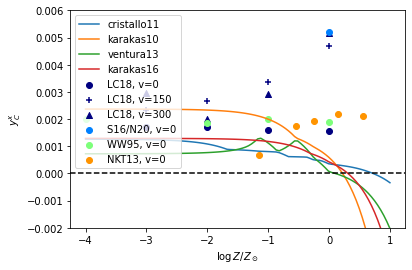

In [45]:
N = len(ccsne_studies)
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        if rotation == 0:
            marker = "o"
        elif rotation == 150:
            marker="+"
        elif rotation == 300:
            marker="^"
        plt.scatter(np.log10(Z), y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=marker)

# plt.axhline(0.002)
#plt.xscale("log")
plt.xlabel("[M/H]")

for model in ["cristallo11", "karakas10","ventura13", "karakas16"]:
    vice.yields.agb.settings["c"] = model
    Zs = 0.014*10**np.linspace(-4, 1, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    
    plt.plot(np.log10(Zs/0.014), np.array(mass_yields)/1e6 - 0.002, label=model)

alpha = 0.001
beta = -20
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel("$y_C^{x}$")

plt.ylim(-2e-3, 6e-3)
plt.axhline(0, c="black", linestyle="--")
# plt.scatter(0, vice.solar_z("c"), marker="*", color="green", label="sun")

plt.legend(loc="upper left")


<ipython-input-46-d7d9521ad60b>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
<ipython-input-46-d7d9521ad60b>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the su

Text(0, 0.5, 'Z_C_eq')

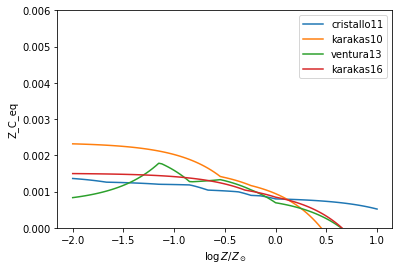

In [46]:

for study in AGB_MODELS:
    def equilibrium_Z_C(Z):
        interpolator = vice.yields.agb.interpolator("c", study=study)
        return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
    log_Z = np.linspace(-2, 1, 100)
    y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
    plt.plot(log_Z, y, label=study)
    
def equilibrium_Z_C(Z):
    interpolator = yields.amplified_yields("c", prefactor=3)
    return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
log_Z = np.linspace(-2, 1, 100)
y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
# plt.plot(log_Z, y, label="3*cristallo11")    

def equilibrium_Z_C(Z):
    interpolator = yields.amplified_yields("c", prefactor=10)
    return scipy.integrate.quad(lambda x: x**-2.3 * interpolator(x, Z), 1, 8)[0]
log_Z = np.linspace(-2, 1, 100)
y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
# plt.plot(log_Z, y, label="10*cristallo11")   
    
plt.legend()
plt.ylim(0, 0.006)
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("Z_C_eq")


In [47]:
for q in [1, 3, 2]:
    def equilibrium_Z_C(Z):
        return scipy.integrate.quad(lambda x: x**-2.3 * y_c_agb()(x, Z), 1, 8)[0]
    log_Z = np.linspace(-4, 1, 100)
    y = [(0.002 + equilibrium_Z_C(0.014*10**z))/(1+2.5-0.4) for z in log_Z]
    plt.plot(log_Z, y, label=q)
plt.legend()
plt.ylim(0)
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("Z_C_eq")
plt.legend

TypeError: 'numpy.ndarray' object is not callable

# Investigation of ratio of CCSNe to AGB for carbon production


In [ ]:
def IMF(m):
    """The Initial Mass Function
    Returns the PDF of a star born with some mass M"""
    norm = 1/3.9
    if m > 0.5:
        return norm * m**-2.3
    elif m > 0.08:
        return norm * m**-1.3
    else:
        return norm * m**-0.3

def m_rem(m):
    """The remenant mass of a star mass m
    Returns the mass of the stellar remanent for a star of mass m"""
    if m >= 8:
        return 1.44
    else:
        return 0.394 + 0.109*m

def integrated_yield(model, Z, m_min=1, m_max = 7):
    if type(model) == str:
        f = vice.yields.agb.interpolator("c", study=model)
    else:
        f = model
    
    return scipy.integrate.quad(lambda m: f(m, Z)* IMF(m) * (m-m_rem(m)), m_min, m_max)[0] 

def Z_eq_c(model, Z):
    if type(model) == str:
        f = vice.yields.agb.interpolator("c", study=model)
    else:
        f = model
    eta = 2.5
    r = 0.4
    return (vice.yields.ccsne.settings("c") + scipy.integrate.quad(lambda m: f(m, Z)* IMF(m)*m, m_min, m_max)[0] )/(1 + eta - r)
    

def calculate_equilibrium_yield(model, Z):
    eta = 2.5
    r = 0.4
    return (integrated_yield(model, Z) + vice.yields.ccsne.settings["c"]) / (1 + eta - r)

In [ ]:
calculate_equilibrium_yield(lambda m, z:0, 0.01)
vice.yields.ccsne.settings["c"] = 0.002
vice.yields.ccsne.settings["o"] = 0.015

In [ ]:
# calculation of equilibrium ccsne yields for [c/o]
np.log10(2*vice.yields.ccsne.settings["c"]/vice.yields.ccsne.settings["o"]) - np.log10(vice.solar_z['c'] / vice.solar_z['o'])

In [ ]:
# from Asplund+09
Z_c_solar = 0.74 * 10**(-12+ 8.43)
Z_o_solar = 0.74 * 10**(-12+8.69)

In [ ]:
Zs = 0.014 * 10**np.linspace(-3,1, 1000)
y = [integrated_yield("cristallo11", Z) for Z in Zs]
log_Z = np.log10(Zs/0.014)
plt.plot(log_Z, y, label="AGB")
plt.plot(log_Z, [0.002]*len(Zs), label="CCSN")
plt.plot(log_Z, np.array(y) + 0.002, label="Total")
plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("$y_C$")

vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0.002

mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

# plt.plot(log_Z, np.array(mass_yields)/1e6, label="SSP")



plt.axhline(0, c="black")

plt.legend()

sf("yields_by_process")

In [ ]:
Zs = 0.014 * 10**np.linspace(-3,1, 1000)
log_Z = np.log10(Zs/0.014)


for model in AGB_MODELS:
    y = np.array([integrated_yield(model, Z) for Z in Zs])

    plt.plot(log_Z, y/(y+0.002), label=model)

plt.xlabel("$\log Z/Z_\odot$")
plt.ylabel("$y_C^{agb}/y_C$")
plt.legend()

plt.ylim(-0.5, 0.5)